In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Load data
train = pd.read_csv("train_volume_vix.csv", parse_dates=["date"])
test = pd.read_csv("test_volume_vix.csv", parse_dates=["date"])

# Drop missing values just in case
train = train.dropna(subset=["vix_close", "target_volume"])
test = test.dropna(subset=["vix_close", "target_volume"])

# add time features to capture seasonality and trends

train["year"] = train["date"].dt.year
train["month"] = train["date"].dt.month
train["dayofweek"] = train["date"].dt.dayofweek

test["year"] = test["date"].dt.year
test["month"] = test["date"].dt.month
test["dayofweek"] = test["date"].dt.dayofweek


In [2]:

# ---------- 1) Build lag features safely (across the split) ----------
# infer split date from your current test set
split_date = pd.to_datetime(test["date"]).min()

# combine, sort, make features
df_all = pd.concat([train, test], ignore_index=True)
df_all["date"] = pd.to_datetime(df_all["date"])
df_all = df_all.sort_values("date")

# lags & changes of VIX
df_all["vix_lag1"]   = df_all["vix_close"].shift(1)
df_all["vix_lag2"]   = df_all["vix_close"].shift(2)
df_all["vix_lag3"]   = df_all["vix_close"].shift(3)
df_all["vix_change"] = df_all["vix_close"].diff()

# drop the first row with NaNs from lag/diff
df_all = df_all.dropna(subset=["vix_lag1", "vix_change"]).reset_index(drop=True)

# re-split
train = df_all[df_all["date"] < split_date].copy()
test  = df_all[df_all["date"] >= split_date].copy()


In [11]:

# ---------- 2) Fit Random Forest on expanded features ----------
feature_cols = ["vix_close", "vix_lag1", "vix_lag2", "vix_lag3", "year", "month"]

X_train = train[feature_cols]
y_train = np.log(train["target_volume"])

X_test  = test[feature_cols]
y_test  = np.log(test["target_volume"])

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=25,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=25, min_samples_split=5, n_estimators=200,
                      n_jobs=-1, random_state=42)

In [12]:

# ---------- 3) Evaluate ----------
y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)
print(f"MSE (log): {mse:.4f}  MAE (log): {mae:.4f}  R² (log): {r2:.3f}")

actual = np.exp(y_test)
pred   = np.exp(y_pred)
mape = (np.abs(pred - actual) / actual).mean() * 100
print(f"MAPE (original scale): {mape:.2f}%")


MSE (log): 0.0323  MAE (log): 0.1214  R² (log): -0.178
MAPE (original scale): 11.37%


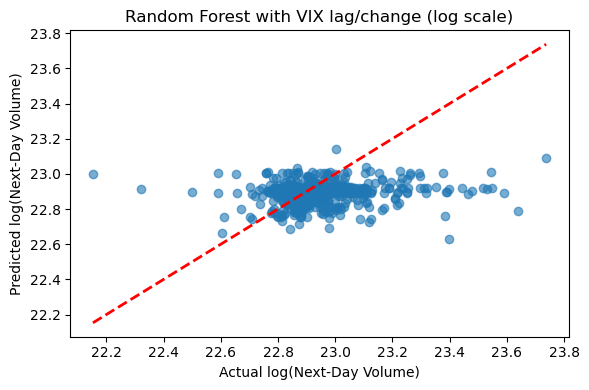

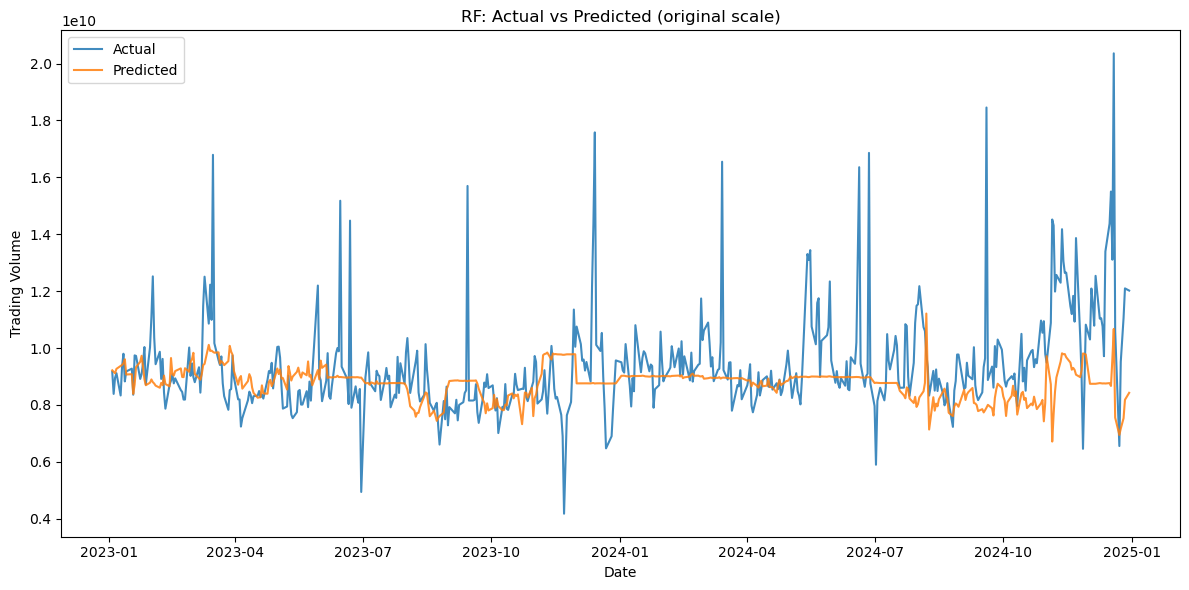

In [13]:

# ---------- 4) Quick visuals ----------
# Actual vs Pred (log)
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred, alpha=0.6)
lo, hi = min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())
plt.plot([lo, hi], [lo, hi], 'r--', lw=2)
plt.xlabel("Actual log(Next-Day Volume)")
plt.ylabel("Predicted log(Next-Day Volume)")
plt.title("Random Forest with VIX lag/change (log scale)")
plt.tight_layout(); plt.show()

# Time series (original scale)
plot_df = test[["date"]].copy()
plot_df["actual_volume"] = actual.values
plot_df["predicted_volume"] = pred

plt.figure(figsize=(12,6))
plt.plot(plot_df["date"], plot_df["actual_volume"], label="Actual", alpha=0.85)
plt.plot(plot_df["date"], plot_df["predicted_volume"], label="Predicted", alpha=0.85)
plt.xlabel("Date"); plt.ylabel("Trading Volume")
plt.title("RF: Actual vs Predicted (original scale)")
plt.legend(); plt.tight_layout(); plt.show()


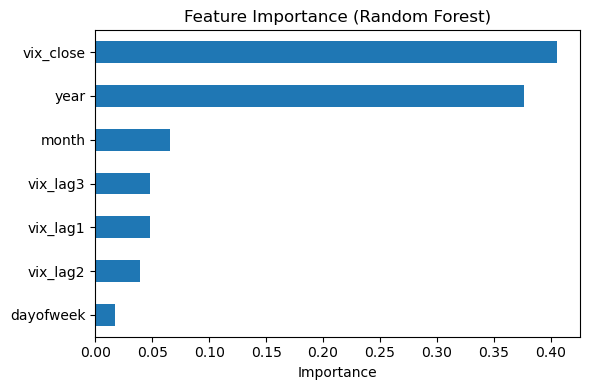

In [10]:

# ---------- 5) Feature importance ----------
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values()
plt.figure(figsize=(6,4))
importances.plot(kind="barh")
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout(); plt.show()
